OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August, September 2022

# PART 2 : Exploratory Data Analysis of the dataset

#### Idea

The variable that we want to predict is : "TotalGHGEmissions" which represents the amount of CO2 emitted.

1) Correlation Matrix :
    - Feature Engineering : delete features that are correlated.

2) Data visualization of "TotalGHGEmissions" and categorical features (like "BuildingType" for instance)

3) Study distribution of quantitative features (energy variables etc)
    - Feature Engineering : verify the coefficient of skewness
    - Feature Engineering : apply logarithmic transformation


#### Importing libraries

In [70]:
%reset -f

import warnings

# warnings.filterwarnings('once')
warnings.filterwarnings(action="ignore")

from exploration import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [71]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', None)

# Starting time
t0 = time()

#### Loading dataset

In [72]:
columns_to_categorize = ["OSEBuildingID", "YearBuilt", "BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode",
                         "CouncilDistrictCode",
                         "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

columns_to_categorize = {column: 'object' for column in columns_to_categorize}

print("This dictionary will be used when reading the csv file to assign a type to categorical features :",
      columns_to_categorize)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'OSEBuildingID': 'object', 'YearBuilt': 'object', 'BuildingType': 'object', 'PrimaryPropertyType': 'object', 'Neighborhood': 'object', 'ZipCode': 'object', 'CouncilDistrictCode': 'object', 'LargestPropertyUseType': 'object', 'SecondLargestPropertyUseType': 'object', 'ThirdLargestPropertyUseType': 'object'}


In [73]:
input_path = "./dataset/cleaned/"
input_filename = "data_cleaned.csv"

input_dataset_file = "{}{}".format(input_path, input_filename)
# we assign the categorical features with a categorical type
cleaned_data = pd.read_csv(input_dataset_file, dtype=columns_to_categorize)

In [74]:
cleaned_data.shape

(1484, 33)

In [75]:
cleaned_data[:10]

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,YearSinceBuilt
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434,No use,0,No use,0,60,82,84,182,189,7226362,7456910,2003882,1156514,3946027,12765,1276453,250,3,95
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880,Parking,15064,Restaurant,4622,61,95,98,176,179,8387933,8664479,0,950425,3242851,51451,5145082,296,3,26
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493,No use,0,No use,0,43,96,98,242,244,72587024,73937112,21566554,14515435,49526664,14938,1493800,2089,2,53
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320,No use,0,No use,0,56,111,113,216,224,6794584,6946800,2214446,811525,2768924,18112,1811213,286,5,96
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445,Parking,68009,Swimming pool,0,75,115,119,211,216,14172606,14656503,0,1573449,5368607,88040,8803998,505,3,42
5,9,Nonresidential cos,Other,98101.0,7,Downtown,1999,1,2,97288,37198,60090,Police station,88830,No use,0,No use,0,NaN,136,142,316,320,12086616,12581712,0,2160444,7371434,47152,4715182,302,3,23
6,10,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,11,83008,0,83008,Hotel,81352,No use,0,No use,0,27,71,74,147,155,5758795,6062768,0,823920,2811215,29476,2947580,176,2,96
7,11,Nonresidential,Other,98101.0,7,Downtown,1926,1,8,102761,0,102761,Other - entertainment/public assembly,102761,No use,0,No use,0,NaN,61,69,142,152,6298132,7067882,2276286,1065843,3636655,3852,385189,222,2,96
8,12,Nonresidential,Hotel,98104.0,7,Downtown,1904,1,15,163984,0,163984,Hotel,163984,No use,0,No use,0,43,84,87,181,187,13723820,14194054,0,2138898,7297919,64259,6425900,392,2,118
9,15,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,11,153163,19279,133884,Hotel,133884,No use,0,No use,0,30,120,124,228,233,16016644,16646930,5237166,1813490,6187627,45918,4591850,691,5,53


In [76]:
cleaned_data.dtypes

OSEBuildingID                       object
BuildingType                        object
PrimaryPropertyType                 object
ZipCode                             object
CouncilDistrictCode                 object
Neighborhood                        object
YearBuilt                           object
NumberofBuildings                    int64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEUI(kBtu/sf)                   float64
SiteEUIWN(kBtu/sf)                 float64
SourceEUI(kBtu/sf)                 float64
SourceEUIWN(kBtu/sf)               float64
SiteEnergyU

In [77]:
cleaned_data.describe().transpose().sort_values(by="max", ascending=True)

,count,mean,std,min,25%,50%,75%,max
GHGEmissionsIntensity,1484,2,2,0,0,1,2,26
NumberofBuildings,1484,1,1,1,1,1,1,27
NumberofFloors,1484,4,7,0,1,2,4,99
ENERGYSTARScore,970,64,29,1,44,71,88,100
YearSinceBuilt,1484,60,33,7,34,56,92,122
SiteEUI(kBtu/sf),1484,74,72,2,35,54,85,834
SiteEUIWN(kBtu/sf),1484,77,73,2,37,56,88,834
SourceEUI(kBtu/sf),1484,182,182,7,81,139,212,2620
SourceEUIWN(kBtu/sf),1484,185,182,7,86,143,216,2620
TotalGHGEmissions,1484,144,289,1,21,50,144,3278


### 1) Correlation Matrix

#### 1) Correlation matrix with all features

Thanks to the correlation matrix below, we will be able to choose the features for the prediction models.

We display here the correlation matrix without options to justify the display below.


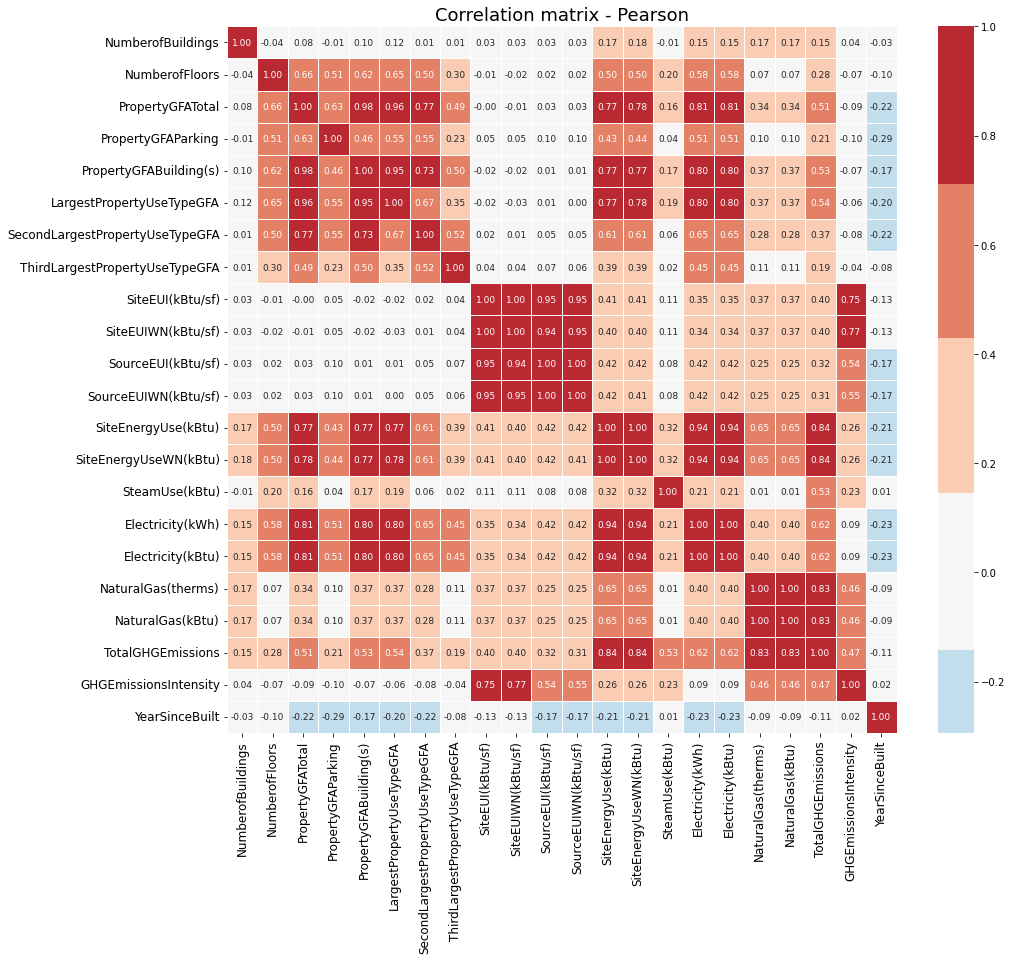

In [78]:
correlation_matrix(cleaned_data, width=15, height=13)

**Interpretation**


1) There are variables used to predict energy (electricity, steam, gas, total energy). These variables are for example YearBuilt, NumberofFloors. **We want these features used for prediction to be correlated to the target which are energy variables**.
However, **we do not want these features to be correlated between each other**.
- We won't keep features that are high correlated to other features used for prediction : PropertyGFABuilding(s), LargestPropertyUseTypeGFA' for instance.

2) The purpose of this project is to predict the CO2 (TotalGHGEmissions) using the energy predictions.
- We won't keep useless energy features : Electricity(kWh), NaturalGas(therms) for instance.
- We choose 4 energy targets (electricity, steam, gas, total energy in kBtu (same unit) ; we drop all the correlated energy features (Weather Normalized, (kBtu/sf).

#### 2) Correlation after cleaning

In [79]:
data_v1 = delete_correlated_variables(cleaned_data)

___Removing correlated features___
Before : (1484, 33)
After : (1484, 22)


We display here the correlation matrix without options to justify the display below.


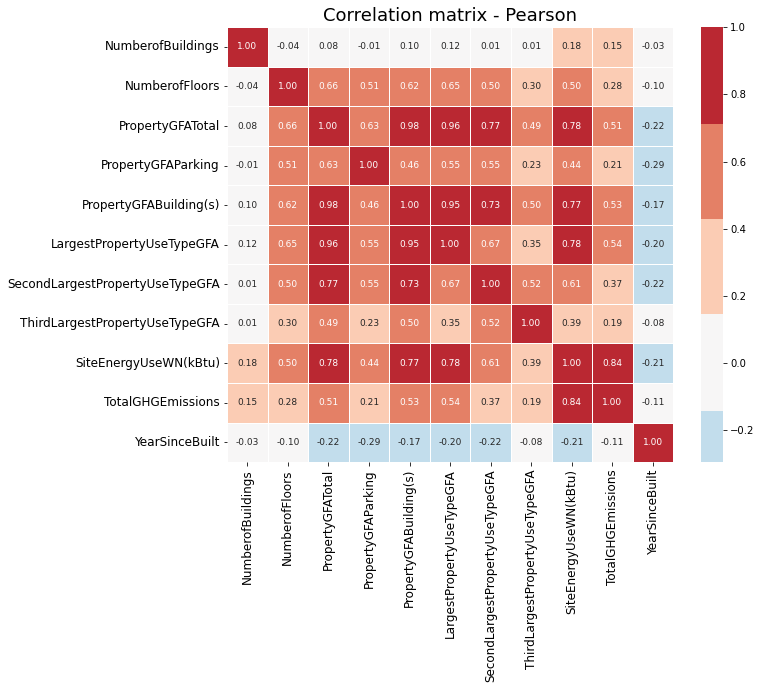

In [80]:
correlation_matrix(data_v1, width=10, height=8)

**Interpretation** :

Features for prediction :
- PropertyGFABuilding(s) or PropertyGFATotal
- NumberofFloors (though really correlated to other building properties)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

Steam(kBtu) is not correlated to building properties, it might be not well predicted.
NaturalGas(kBtu) being only correlated to ThirdLargestPropertyUseTypeGFA, it might be not well predicted.


### 2) Boxplot

In [81]:
features_to_predict = ["SiteEnergyUseWN(kBtu)",
                       "TotalGHGEmissions"]

print("Features to predict : ", features_to_predict)

Features to predict :  ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


#### 1) Distribution of the targets (variables to predict)

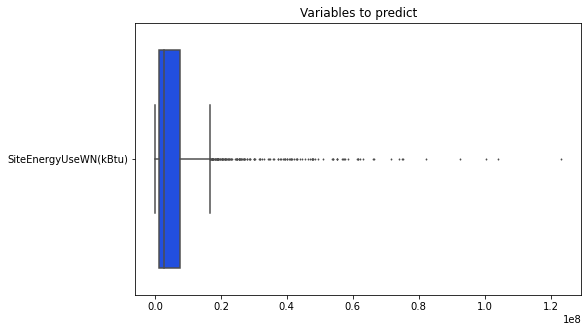

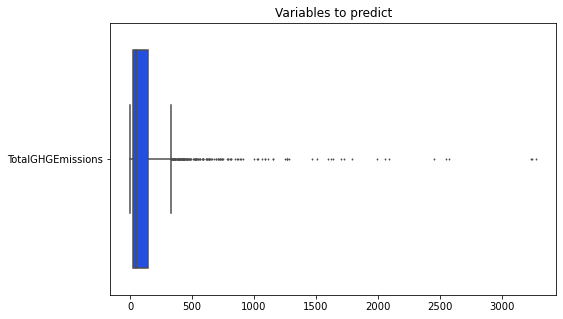

In [82]:
for index, feature in enumerate(features_to_predict):
    # Boxplot of features to predict
    plt.figure(figsize=(8, 5))
    plt.title('Variables to predict')
    bp = sns.boxplot(x='value', y='variable', data=pd.melt(data_v1[[feature]]), palette='bright',
                     flierprops=dict(markersize=1, markerfacecolor='gray'))
    bp.set_xlabel("")
    bp.set_ylabel("")
    plt.show()

#### 2) variables to predict as a function of categorical variables

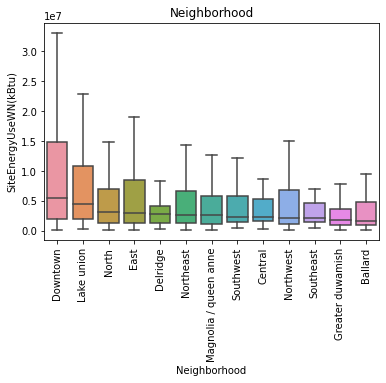

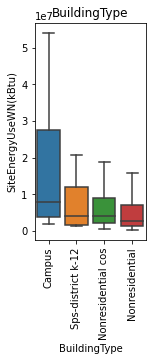

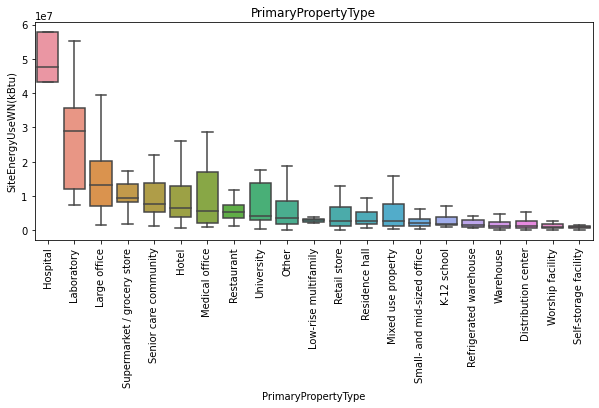

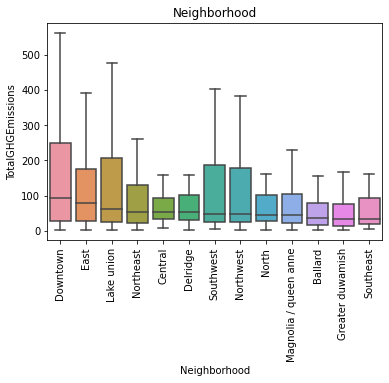

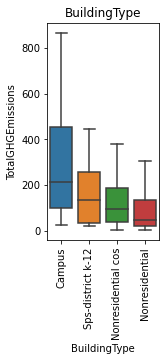

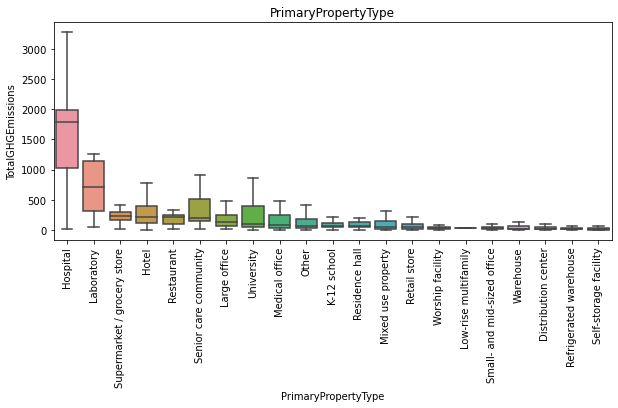

In [83]:
categorical_features = ["Neighborhood", "BuildingType", "PrimaryPropertyType"]

for feature_to_predict in features_to_predict:
    for feature in categorical_features:
        box_categorical(data_v1, col_categorical=feature, col_numeric=feature_to_predict)

### 3) Distribution of quantitative / numerical variables

#### 1) Skewness

In [84]:
print("These are the features that need a transformation :")
skew_features = get_features_skewness(data_v1)
print(skew_features)

These are the features that need a transformation :
___Getting features with skewness greater than 2___
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


Density distribution of all numerical variables :
___Density distribution___


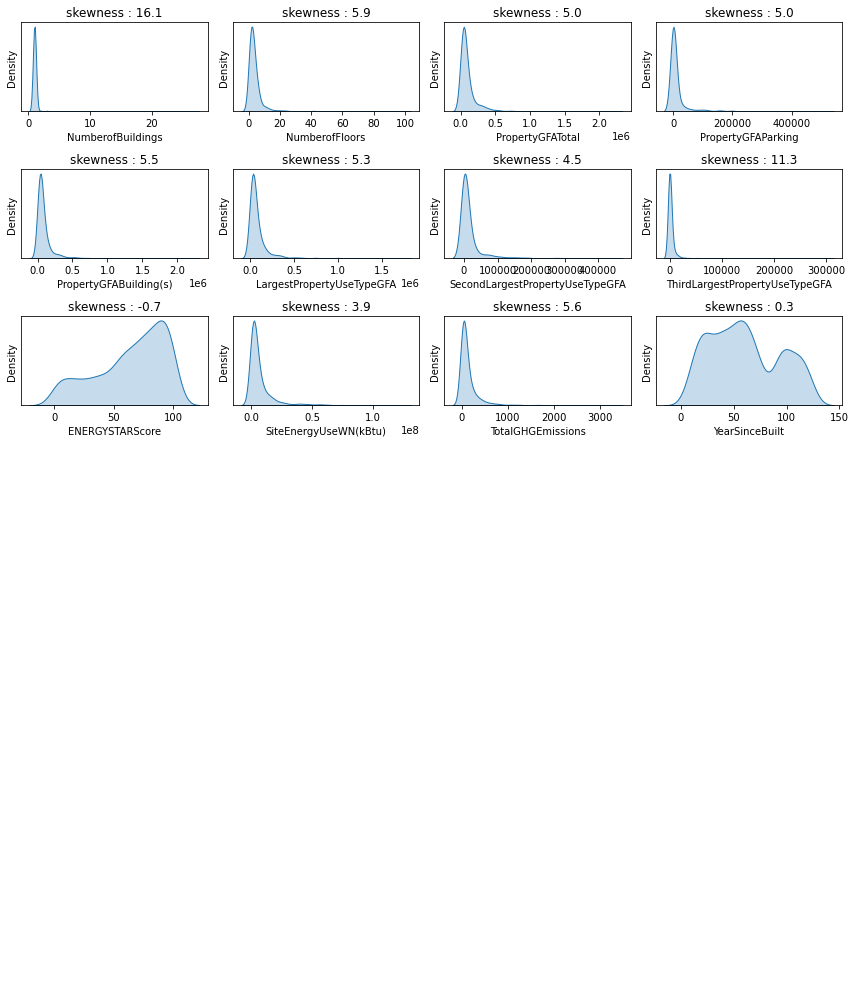

In [85]:
print("Density distribution of all numerical variables :")
density(data_v1)

#### 2) Logarithmic transformation

In [86]:
print("We check the effect of a log transformation on the variable we want to predict.")

We check the effect of a log transformation on the variable we want to predict.


In [87]:
print("Trying different log transformations :")
test_log = compute_log_effect_on_skewness(data_v1, skew_features)

pd.set_option('display.float_format', lambda x: '%.6f' % x)
display(test_log)

print("We can see that using log base 2, lob base 10 or natural ln is the same here.")

Trying different log transformations :


,feature,ln(1+x),log-2(1+x),log-10(1+x)
0,NumberofBuildings,8.483817,8.483817,8.483817
0,NumberofFloors,1.268754,1.268754,1.268754
0,PropertyGFATotal,1.046246,1.046246,1.046246
0,PropertyGFAParking,1.413870,1.413870,1.413870
0,PropertyGFABuilding(s),1.097000,1.097000,1.097000
0,LargestPropertyUseTypeGFA,0.833533,0.833533,0.833533
0,SecondLargestPropertyUseTypeGFA,0.112269,0.112269,0.112269
0,ThirdLargestPropertyUseTypeGFA,1.503743,1.503743,1.503743
0,SiteEnergyUseWN(kBtu),0.294715,0.294715,0.294715
0,TotalGHGEmissions,0.118723,0.118723,0.118723


We can see that using log base 2, lob base 10 or natural ln is the same here.


___Log transformation pipeline___
Before : (1484, 22)
These are the features that need a transformation :
___Getting features with skewness greater than 2___
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
Before :
___Density distribution___


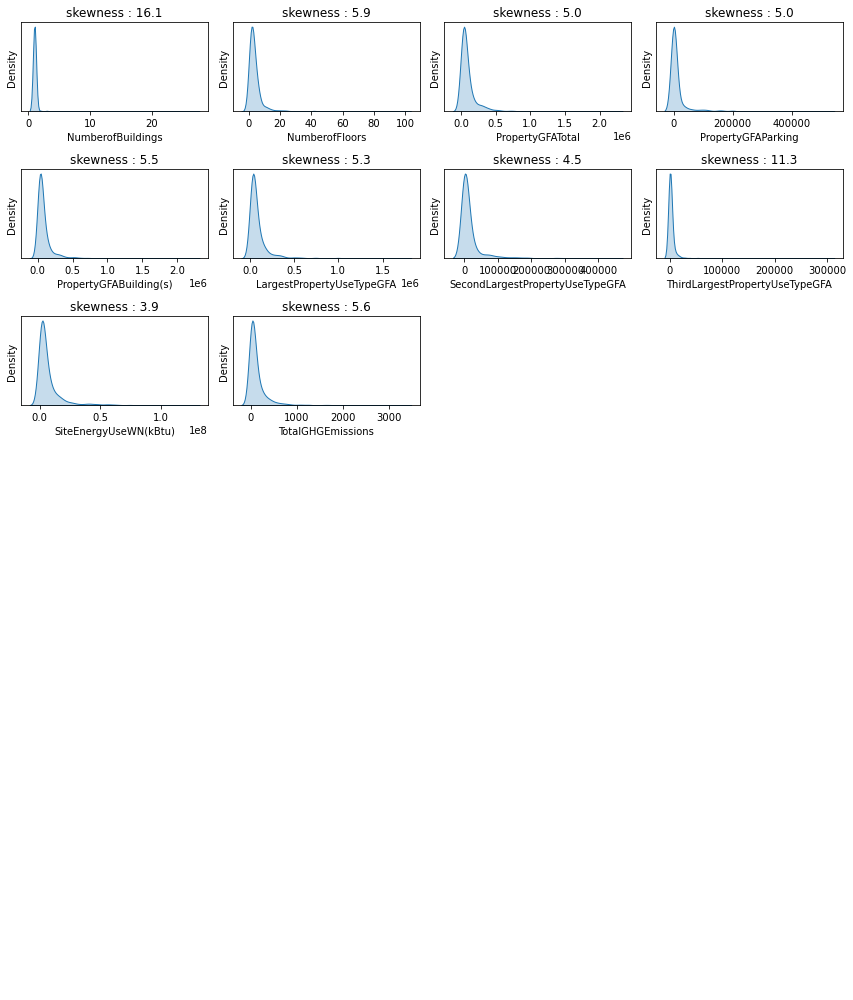

___Logarithmic transformation of features___
Log-transformation of the variables to predict.
___Density distribution___


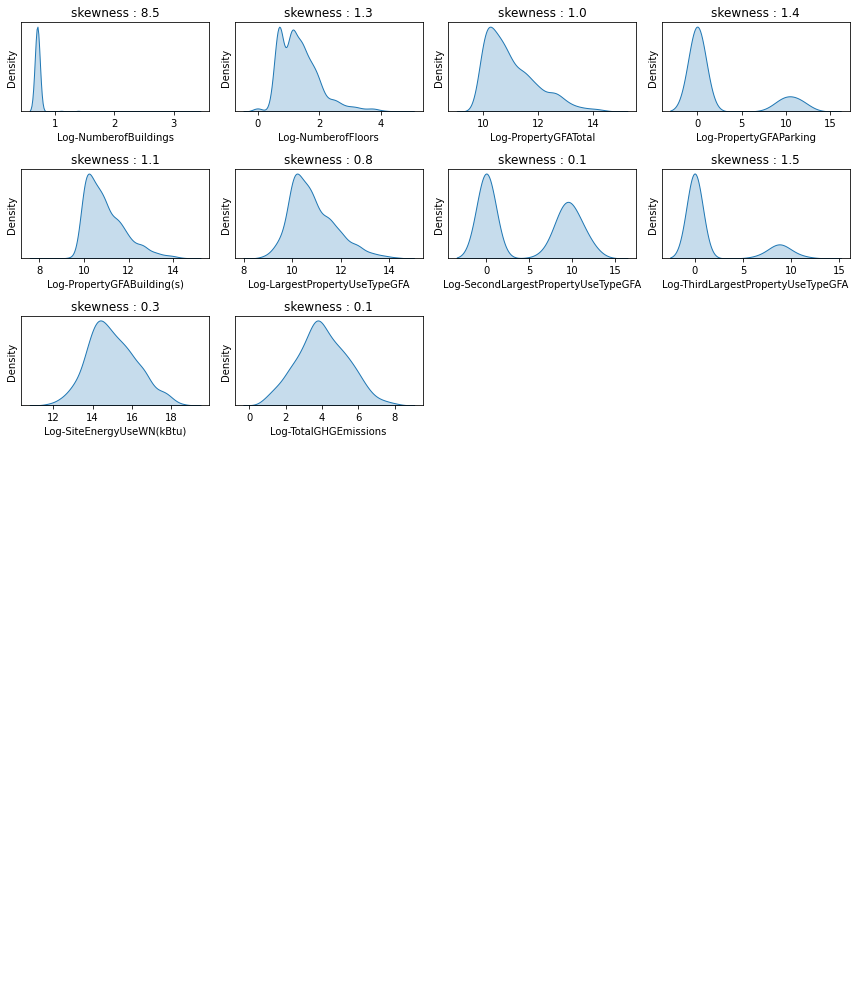

After : (1484, 32)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,YearSinceBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu),Log-TotalGHGEmissions
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434.000000,No use,0.000000,No use,0.000000,60.000000,7456910.000000,249.980000,95,0.693147,2.564949,11.390023,0.000000,11.390023,11.390023,0.000000,0.000000,15.824652,5.525373
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880.000000,Parking,15064.000000,Restaurant,4622.000000,61.000000,8664479.000000,295.860000,26,0.693147,2.484907,11.547974,9.620129,11.390792,11.337154,9.620129,8.438799,15.974742,5.693261
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493.000000,No use,0.000000,No use,0.000000,43.000000,73937112.000000,2089.280000,53,0.693147,3.737670,13.770629,12.189532,13.540275,13.536450,0.000000,0.000000,18.118725,7.645053
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320.000000,No use,0.000000,No use,0.000000,56.000000,6946800.500000,286.430000,96,0.693147,2.397895,11.023878,0.000000,11.023878,11.023878,0.000000,0.000000,15.753792,5.660979
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445.000000,Parking,68009.000000,Swimming pool,0.000000,75.000000,14656503.000000,505.010000,42,0.693147,2.944439,12.075856,11.034906,11.640272,11.723559,11.127410,0.000000,16.500395,6.226556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,50069,Nonresidential,Small- and mid-sized office,98108.0,2,Greater duwamish,1929,1,2,24990,0,24990,Office,24990.000000,No use,0.000000,No use,0.000000,9.000000,4731813.500000,134.800000,93,0.693147,1.098612,10.126271,0.000000,10.126271,10.126271,0.000000,0.000000,15.369819,4.911183
1480,50070,Nonresidential,Other,98155.0,4,Northeast,2013,1,1,72000,0,72000,Other - recreation,72000.000000,No use,0.000000,No use,0.000000,NaN,3198858.000000,67.650000,9,0.693147,0.693147,11.184435,0.000000,11.184435,11.184435,0.000000,0.000000,14.978305,4.229021
1481,50081,Nonresidential,K-12 school,98144.0,3,Greater duwamish,2015,1,3,45000,0,45000,K-12 school,45728.000000,Parking,0.000000,No use,0.000000,77.000000,1397742.375000,9.240000,7,0.693147,1.386294,10.714440,0.000000,10.714440,10.730488,0.000000,0.000000,14.150370,2.326302
1482,50094,Nonresidential,Mixed use property,98109.0,7,Lake union,2015,1,6,345290,85028,260262,Laboratory,151523.000000,Office,106498.000000,Parking,84002.000000,NaN,41078600.000000,1000.060000,7,0.693147,1.945910,12.752143,11.350748,12.469448,11.928499,11.575891,11.338608,17.530998,6.908815


In [88]:
data_v2 = log_transformation_based_on_skewness(data_v1)
display(data_v2)

### 4) Keeping only relevant features

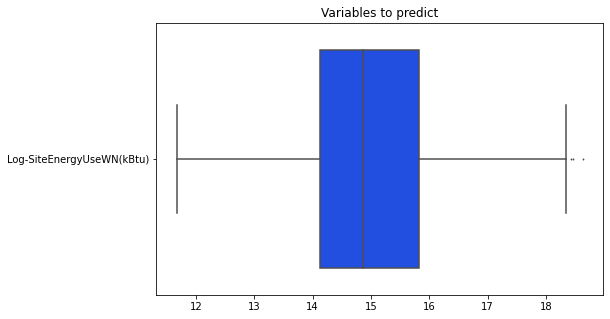

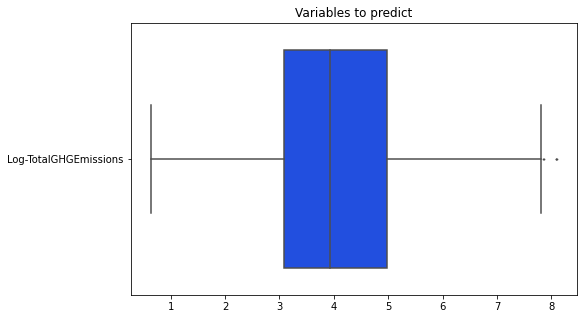

In [89]:
# Boxplot of features to predict
features_to_predict = ["Log-SiteEnergyUseWN(kBtu)", "Log-TotalGHGEmissions"]

for index, feature in enumerate(features_to_predict):
    plt.figure(figsize=(8, 5))
    plt.title('Variables to predict')
    bp = sns.boxplot(x='value', y='variable', data=pd.melt(data_v2[[feature]]), palette='bright',
                     flierprops=dict(markersize=1, markerfacecolor='gray'))
    bp.set_xlabel("")
    bp.set_ylabel("")
    plt.show()

In [90]:
prediction_features = ["Neighborhood", "BuildingType", "PrimaryPropertyType",
                       "ENERGYSTARScore",

                       'Log-NumberofFloors',
                       'Log-PropertyGFATotal',
                       'Log-PropertyGFABuilding(s)',

                       'Log-LargestPropertyUseTypeGFA',
                       'Log-SecondLargestPropertyUseTypeGFA']
# , "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType",
# 'Log-PropertyGFAParking',    'Log-NumberofBuildings', # ,'Log-ThirdLargestPropertyUseTypeGFA' # ,"YearSinceBuilt",


target_features = [
    'Log-SiteEnergyUseWN(kBtu)',
    'Log-TotalGHGEmissions']

data_v3 = data_v2[prediction_features + target_features]

### 5) Saving cleaned dataset

In [91]:
# We reset the index
#final_dataset = dataset_v3.reset_index(drop=True)

# Save
output_path = "./dataset/cleaned/"
output_filename = "TESTdata_exploration.csv"
output_dataset_file = "{}{}".format(output_path, output_filename)

data_v3.to_csv(output_dataset_file, index=False)

In [92]:
# End of pipeline time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 11.977407 sec
computing time : 00:00:11
